In [1]:
import os,time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from glob import glob
from tensorflow.keras import layers

In [2]:
import ipynb_importer
from myutils import make_anime_dataset,visualize_result,clear_imgs,train_time_log,set_memory_growth
from styleGAN_layers import Dense,Conv2D

importing Jupyter notebook from myutils.ipynb
importing Jupyter notebook from styleGAN_layers.ipynb


In [3]:
print(tf.__version__)

os.environ['TF_XLA_FLAGS']='--tf_xla_enable_xla_devices --tf_xla_auto_jit=fusible --tf_xla_cpu_global_jit --tf_xla_always_defer_compilation=false --tf_xla_enable_lazy_compilation=true'

tf.config.optimizer.set_jit(True)
print('jit:',tf.config.optimizer.get_jit())

2.4.1
jit: True


In [4]:
os.environ['TF_GPU_THREAD_MODE']='gpu_private'

In [5]:
if 0:
    set_memory_growth()

In [6]:
upsample_method='bilinear' #共3处，GT，G_block,Generator

ckpt_dir="./checkpoints/PGGAN"
re_dir="./results/PGGAN"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
if not os.path.exists(re_dir):
    os.makedirs(re_dir)

In [7]:
def process_real_image(x,cur_res,alpha=1.0):
    x=tf.image.resize(x,(cur_res,cur_res))
    if (alpha >= 1.0) :
        return x
    else:
        y=tf.image.resize(x,(cur_res//2,cur_res//2))
        y=tf.image.resize(x,(cur_res,cur_res),method=upsample_method)
        return lerp_clip(y,x,alpha)

def get_ckpt_path(cur_res):
    G_path=os.path.join(ckpt_dir,'generator{0}x{0}.h5'.format(cur_res))
    D_path=os.path.join(ckpt_dir,'discriminator{0}x{0}.h5'.format(cur_res))
    return D_path,G_path

def get_train_steps(base_n=1000,increase_n=1000,target_res=64,batch_size=1):
    res=4
    re={}
    while (res <= target_res):
        re[res]=int(base_n+increase_n*np.floor(np.log2(res/4)))//batch_size
        res*=2
    return re
    
def prepare_model(resolution,G_before_D=False,load=False,same_res=False,compile_optimizer=False):
    #functional API不用build
    D=Discriminator(resolution)
    G=Generator(resolution)
    
    if compile_optimizer is True:
        global cur_lr,optimizer_name
        d_op,g_op=prepare_optimizer(cur_lr,optimizer_name)
        D.compile(d_op)
        G.compile(g_op)
        
    if load is True:
        if not same_res:
            assert resolution > 4
            resolution=resolution//2
        D_path,G_path=get_ckpt_path(resolution)
        D.load_weights(D_path,by_name=True)
        G.load_weights(G_path,by_name=True)
    
    if G_before_D:
        return G,D
    else:
        return D,G

def prepare_optimizer(learning_rate,optimizer,beta1=0.,beta2=0.99):
    if (type(learning_rate) is float):
        d_lr=g_lr=learning_rate
    else:
        d_lr,g_lr=[learning_rate[0],learning_rate[1]]
    print('d_learning_rate={:.3e},g_learning_rate={:.3e}'.format(d_lr,g_lr))
    
    if (str.lower(optimizer) == 'rmsprop'):
        d_optimizer= tf.keras.optimizers.RMSprop(learning_rate=d_lr)
        g_optimizer= tf.keras.optimizers.RMSprop(learning_rate=g_lr)
    elif (str.lower(optimizer) == 'adam'):
        d_optimizer= tf.keras.optimizers.Adam(learning_rate=d_lr,beta_1=beta1,beta_2=beta2)
        g_optimizer= tf.keras.optimizers.Adam(learning_rate=g_lr,beta_1=beta1,beta_2=beta2)
    assert d_optimizer is not None
    return d_optimizer,g_optimizer

In [8]:
#将layer替换成tf的resize
def Generator(resolution=1024):
    resolution_log2=int(np.log2(resolution))
    assert resolution == 2**resolution_log2 and resolution >= 4
    
    inputs=layers.Input((100,),name='GInput')
    alpha=layers.Input((),batch_size=1,name='GAlpha')
    
    x=g_ConvBlock(2,name='g_block{0}x{0}'.format(4))(inputs)
    image=toRGB(name='toRGB{0}x{0}'.format(4))(x)
    
    for i in range(3,resolution_log2+1):
        cur_res=2**i
        x=g_ConvBlock(i,name='g_block{0}x{0}'.format(cur_res))(x)
        img=toRGB(name='toRGB{0}x{0}'.format(cur_res))(x)
        
        if (i == resolution_log2):
            image=tf.image.resize(image,(cur_res,cur_res),method=upsample_method)
#             image=layers.UpSampling2D(interpolation=upsample_method,name='upsample{}to{}'.format(cur_res//2,cur_res))(image)
            image=lerp_clip(image,img,alpha)
        else:
            image=img
            
    model=tf.keras.Model(inputs=[inputs,alpha],outputs=image)
    return model

In [9]:
# tf.keras.utils.plot_model(Generator(8),show_shapes=True)

In [10]:
def Discriminator(resolution=1024):
    resolution_log2=int(np.log2(resolution))
    assert resolution == 2**resolution_log2 and resolution >= 4
    
    inputs=layers.Input((resolution,resolution,3),name='DInput')
    alpha=layers.Input((),batch_size=1,name='DAlpha')
    
    x=fromRGB(resolution_log2,name='fromRGB{0}x{0}'.format(resolution))(inputs)
    for i in range(resolution_log2,2,-1):
        cur_res=2**i
        x=d_ConvBlock(i,name='d_block{0}x{0}'.format(cur_res))(x)
        if (i == resolution_log2):
            img=layers.AvgPool2D(name='downsample{}'.format(i))(inputs)
            y=fromRGB(level=i-1,name='fromRGB{0}x{0}'.format(resolution//2))(img)
            x=lerp_clip(y,x,alpha)
    x=d_ConvBlock(2,name='d_block4x4')(x)
    
    model=tf.keras.Model(inputs=[inputs,alpha],outputs=x)
    return model

In [11]:
# tf.keras.utils.plot_model(Discriminator(8),show_shapes=True)

In [12]:
class g_ConvBlock(layers.Layer):
    def __init__(self,level,kernel_size=3,norm_latent=True,name=None):
        super(g_ConvBlock,self).__init__(name=name)
        
        assert level >=2
        self.level=level
        self.norm_latent=norm_latent
        
        if level > 2:
            self.upsample=layers.UpSampling2D(interpolation=upsample_method,name=name+'_upsample')
            self.conv1=Conv2D(nf(level-1),kernel_size=kernel_size,strides=1,name=name+'_conv1')
            self.conv2=Conv2D(nf(level-1),kernel_size=kernel_size,strides=1,name=name+'_conv2')
        else:
            self.fc=Dense(nf(1)*16,name=name+'_dense')
            self.conv=Conv2D(nf(1),kernel_size=kernel_size,strides=1,name=name+'_conv')
        self.PN=PixelNorm()
            
    def call(self,inputs,training=False):
        if self.level > 2:
            x=self.upsample(inputs)
            x=self.PN(self.conv1(x))
            x=self.PN(self.conv2(x))
        else:
            if self.norm_latent:
                inputs=self.PN(inputs)
            x=self.PN(self.fc(inputs))
            x=tf.reshape(x,[-1,4,4,nf(1)])
            x=self.PN(self.conv(x))
        
        return x
    
class toRGB(layers.Layer):
    def __init__(self,filters=3,name=None):
        super(toRGB,self).__init__(name=name)
        
        self.conv=Conv2D(filters=filters,kernel_size=1,strides=1,activation=None,name=name+'_conv')
        
    def call(self,inputs,training=None):
        x=self.conv(inputs)
        return x
    
class d_ConvBlock(layers.Layer):
    def __init__(self,level,kernel_size=3,mbstd_groups_size=4,features=1,name=None):
        super(d_ConvBlock,self).__init__(name=name)
        
        assert level >=2
        self.level=level
        
        if level > 2:
            self.conv1=Conv2D(nf(level-1),kernel_size=kernel_size,strides=1,name=name+'_conv1')
            self.conv2=Conv2D(nf(level-2),kernel_size=kernel_size,strides=1,name=name+'_conv2')
            self.downsample=layers.AveragePooling2D(name=name+'_downsample')
        else:
            if mbstd_groups_size > 1:
                self.mbstd=MinibatchStd(mbstd_groups_size,features,name=name+'_mbstd')
            self.conv=Conv2D(nf(1),kernel_size=kernel_size,strides=1,name=name+'_conv')
            self.flatten=layers.Flatten(name=name+'_flatten')
            self.fc1=Dense(nf(0),name=name+'_dense1')
            self.fc2=Dense(1,activation=None,name=name+'_dense2')
    
    def call(self,inputs,training=False):
        if self.level > 2:
            x=self.conv1(inputs)
            #x=_blur2d(x)
            x=self.conv2(x)
            x=self.downsample(x)
        else:
            if self.mbstd is not None:
                inputs=self.mbstd(inputs)
            x=self.conv(inputs)
            x=self.flatten(x)
            x=self.fc1(x)
            x=self.fc2(x)
        
        return x

class fromRGB(layers.Layer):
    def __init__(self,level,name=None):
        super(fromRGB,self).__init__(name=name)
        
        self.conv=Conv2D(filters=nf(level-1),kernel_size=1,strides=1,name=name+'_conv')
        
    def call(self,inputs,training=None):
        x=self.conv(inputs)
        return x

class MinibatchStd(layers.Layer):
    def __init__(self,group_size,num_new_features,**kargs):
        super().__init__(**kargs)
        self.group_size=group_size
        self.num_new_features=num_new_features
    
    def call(self,x):
        x=tf.transpose(x,perm=[0,3,1,2])# [NHWC]->[NCHW]
        group_size=tf.minimum(self.group_size,tf.shape(x)[0])
        s=x.shape
        y=tf.reshape(x,
                    [group_size,-1,self.num_new_features,s[1]//self.num_new_features,s[2],s[3]])
        y=tf.cast(y,tf.float32)
        y-=tf.reduce_mean(y,axis=0,keepdims=True)
        y=tf.reduce_mean(tf.square(y),axis=0)
        y=tf.sqrt(y+1e-8)
        y=tf.reduce_mean(y,axis=[2,3,4],keepdims=True)
        y=tf.reduce_mean(y,axis=[2])
        y=tf.cast(y,x.dtype)
        y=tf.tile(y,[self.group_size,1,s[2],s[3]])
        x=tf.concat([x,y],axis=1)
        x=tf.transpose(x,perm=[0,2,3,1])
        return x
    
class PixelNorm(layers.Layer):
    def __init__(self,**kargs):
        super().__init__(**kargs)
    
    def call(self,x,epsilon=1e-8):
        axis=3 if len(x.shape) > 2 else 1
        #乘rsqrt比除以sqrt效率高
        return x*tf.math.rsqrt(tf.reduce_mean(tf.square(x),axis=axis,keepdims=True)+epsilon)

In [13]:
def lerp_clip(a,b,t):
    return a+(b-a)*tf.clip_by_value(t,0.0,1.0)

def nf(stage, fmap_base=8192, fmap_decay=1.0, fmap_max=512): 
    return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)

In [14]:
@tf.function
def gradient_penalty(D,real,fake,alpha):
    t=tf.random.uniform([real.shape[0],1,1,1])
    t=tf.broadcast_to(t, real.shape)
    interplate= t*real + (1-t)*fake
    
    with tf.GradientTape() as tape:
        tape.watch([interplate])
        d_interplate_logits=D([interplate,alpha])
    grads=tape.gradient(d_interplate_logits,interplate)
    
    grads=tf.reshape(grads,[grads.shape[0], -1])
    gp=tf.norm(grads,axis=1)
    gp=tf.reduce_mean((gp-1)**2)
    return gp

# @tf.function
def d_loss_fn(G,D,noise,batch_x,alpha):
    fake_image= G([noise,alpha])
    d_fake_logits= D([fake_image,alpha])
    d_real_logits= D([batch_x,alpha])
    
#     t=K.random_uniform((batch_x.shape[0],1,1,1))
#     t=tf.broadcast_to(t,batch_x.shape)
#     interplate=t*batch_x + (1-t)*fake_image

#     with tf.GradientTape() as tape:
#         tape.watch([interplate])
#         d_interplate_logits=D([interplate,alpha])
#     grads=tape.gradient(d_interplate_logits,interplate)
#     grads=tf.reshape(grads,[grads.shape[0],-1])
#     gp=tf.norm(grads,axis=1)
#     gp=tf.reduce_mean((grads-1.)**2)

    gp=gradient_penalty(D,batch_x,fake_image,alpha)
    W=tf.reduce_mean(d_fake_logits - d_real_logits)
    loss=W + gp_lambda*gp

    return loss,d_real_logits,W

# @tf.function
def g_loss_fn(G,D,noise,batch_x,alpha):
    fake_image= G([noise,alpha])
    d_fake_logits= D([fake_image,alpha])
    loss=tf.reduce_mean(-d_fake_logits)
    
    return loss

In [15]:
# @tf.function
def D_train_step(G,D,x,alpha):
    noise=K.random_normal((batch_size,z_dim))
    with tf.GradientTape() as tape:
        d_loss,real_logits,W= d_loss_fn(G,D,noise,x,alpha)
#     grads = tape.gradient(d_loss, D.trainable_variables)
#     D.optimizer.apply_gradients(zip(grads, D.trainable_variables))
    D.optimizer.minimize(d_loss, D.trainable_variables,tape=tape)
    return d_loss,tf.reduce_mean(real_logits),W
 
# @tf.function
def G_train_step(G,D,x,alpha):
    noise=K.random_normal((batch_size,z_dim))
    with tf.GradientTape() as tape:
        g_loss= g_loss_fn(G,D,noise,x,alpha)
#     grads = tape.gradient(g_loss, G.trainable_variables)
#     G.optimizer.apply_gradients(zip(grads, G.trainable_variables))
    G.optimizer.minimize(g_loss, G.trainable_variables,tape=tape)
    return g_loss

In [16]:
class TrainScheduler:
    '''
    需要预先定义skpt_dir，在该文件夹下以txt的形式保存训练进度
    会恢复cur_res,cur_lr,resume_step；D,G及其optimizer
    '''
    def __init__(self,resume=False):
        global ckpt_dir
        self.sch_path=os.path.join(ckpt_dir,'schedule.txt')
        if not os.path.exists(self.sch_path):
            with open(self.sch_path,'w') as f:
                f.write('')
        elif resume is True:
            self.resume_train()
    
        
    def pause_train(self):
        global resume_step,step
        try:
            loc_step=resume_step+step
        except NameError:
            loc_step=step
        f=open(self.sch_path,'r+')
        f.truncate()
        print('cur_res=%d' % cur_res,'step=%d' % loc_step,'cur_lr=%e' % cur_lr,sep='\n',file=f)
        f.close()
        
    
    def resume_train(self,lower=False):
        global cur_res,cur_lr,resume_step,D,G
        
        def get_digit_string(f):
            s=f.readline()
            print(s)
            pos=s.find('=')+1
            return s[pos:]

        f=open(self.sch_path,'r+')
        cur_res=int(get_digit_string(f))
        resume_step=int(get_digit_string(f))
        cur_lr=float(get_digit_string(f))
        f.close()
        
        if lower is False:
            D,G=prepare_model(cur_res,load=True,same_res=True,compile_optimizer=True)
        else:
            resume_step=99999
            D,G=prepare_model(cur_res,load=True,same_res=False,compile_optimizer=True)
            cur_res//=2

In [17]:
#准备数据集
input_size=64
z_dim=100
batch_size=4

paths= glob(r'.\faces\*.jpg')
print("read images of",len(paths))
dataset,size= make_anime_dataset(paths,batch_size,resize=(input_size,input_size),return_size=True)
print(size)
data_iter=iter(dataset)

read images of 51223
(64, 64, 3)


In [18]:
learning_rate=2e-4
cur_lr=learning_rate
optimizer_name='adam'

cur_res=4
gp_lambda=8.

shift_imgs=0.5e4
shift_step=int(np.ceil(shift_imgs/batch_size/1e3))*1000
alpha_increase=1.0/shift_step

save_step=100
display_step=50

alpha=tf.Variable(1.0,trainable=False)
D,G=prepare_model(4,compile_optimizer=True)

train_schedule=get_train_steps(base_n=2e4,increase_n=-4e3,batch_size=batch_size)
print(train_schedule)

d_learning_rate=2.000e-04,g_learning_rate=2.000e-04
{4: 5000, 8: 4000, 16: 3000, 32: 2000, 64: 1000}


In [19]:
# logdir=r'D:\jupyter\checkpoints\PGGAN\profiler'

# writer=tf.summary.create_file_writer(logdir)

# with writer.as_default():
#     tf.profiler.experimental.start(logdir)
    
#     dataset= make_anime_dataset(paths,batch_size,resize=(input_size,input_size),return_size=False)
#     data_iter=iter(dataset)
#     x=process_real_image(next(data_iter)[0],cur_res,alpha)
#     try:
#         for i in range(5):
# #             with tf.profiler.experimental.Trace('train',
# #                                                 step_num=i, _r=1):
#             loss,_,_=D_train_step(G,D,x,alpha)
#             tf.summary.scalar(
#                     'Train/Loss', data=loss, step=i)
#     except Exception as e:
#         tf.profiler.experimental.stop()
#         raise e
#     else:
#         tf.profiler.experimental.stop()

In [20]:
if 0:
    clear_imgs(re_dir)

train_sch=TrainScheduler()

if 0:
    train_sch.resume_train(lower=False)
else:
    try:
        alpha=alpha_increase*resume_step
    except NameError:
        print('resume_step not existing')
    finally:
        resume_step=0
print(resume_step)
print('cur_res=%d' % cur_res)

resume_step not existing
0
cur_res=4


step= 0000, d_loss= 3.8013458252, g_loss= 0.3677308261, d_real= -0.1804591417, EM_dist= -0.0733585060


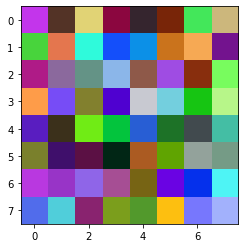

step= 0050, d_loss= -0.8568097949, g_loss= 0.8990772963, d_real= -0.0841032267, EM_dist= -0.9792104959


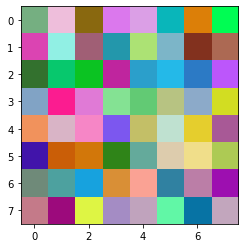

0073/5000 73 steps in 9.227s, 126.4ms per
Interrupted
Train End


In [21]:
while (cur_res <= input_size):
    if (cur_res == 4):
        total_step=train_schedule[4]
    else:
        total_step=shift_step+train_schedule[cur_res]
        
    start_time=time.time()
    total_step-=resume_step
    alpha=tf.Variable(alpha_increase*resume_step,trainable=False,name='alpha')
    
    try:
        noise=K.random_normal((batch_size,z_dim))
        for step in range(total_step+1):
            #准备数据
            print("\r%04d/%04d " % (step,total_step),end='')
            alpha.assign_add(alpha_increase)
            x=next(data_iter)[0]
            x=process_real_image(x,cur_res,alpha)

            #训练
            d_loss,d_real,W = D_train_step(G,D,x,alpha)
            g_loss = G_train_step(G,D,x,alpha)

            #可视化与保存
            if step%display_step == 0 :
                print("\rstep= %04d, d_loss= %.10f, g_loss= %.10f, d_real= %.10f, EM_dist= %.10f"
                          % (step,float(d_loss),float(g_loss),float(d_real),W))
                img_path=os.path.join(re_dir,"PGGAN{0}x{0}_{1:04d}.jpg".format(cur_res,step))
                visualize_result(G,[noise,alpha],save_path=img_path,save=True,rewind=False)

                if (step%save_step == 0 and step != 0):
                    #保存
                    D_path,G_path=get_ckpt_path(cur_res)
                    D.save_weights(D_path)
                    G.save_weights(G_path)


        if (cur_res*2 > input_size): break

        print('change resolution from %d to %d' % (cur_res,cur_res*2))
        D_path,G_path=get_ckpt_path(cur_res)
        D.save_weights(D_path)
        G.save_weights(G_path)
        train_time_log(time.time()-start_time,total_step)

        resume_step=0
        alpha.assign(0.0)
        cur_res*=2
        D,G=prepare_model(cur_res,load=True,compile_optimizer=True)
        visualize_result(G,[noise,alpha], save=False,rewind=True)
        train_time_log(time.time()-start_time,total_step)
        print('start training at {0}x{0}'.format(cur_res))
        print("Current learning rate=%.3e" % (cur_lr))
    except KeyboardInterrupt:
        train_sch.pause_train()
        train_time_log(time.time()-start_time,step)
        print("Interrupted")
        break
            
print("Train End")